Some code are modified from https://tiao.io/post/polya-gamma-bayesian-logistic-regression/. But honestly, the post is hard to understand due to use different notations than I am used to.

In the end, I follow this post, which is much easier to understand.
https://tommasorigon.github.io/CompStat/slides/un_C2.pdf

Finally, in order to make it work in windows, I have to use polyagamma sampler from  https://github.com/zoj613/polyagamma

This part is not interesting as it is just generating data

In [1]:
import numpy as np

def draw_samples(num_samples, p, q, rate=0.5, random_state=None):
    num_top = int(num_samples * rate)
    num_bot = num_samples - num_top

    X_top = p.rvs(size=num_top, random_state=random_state)
    X_bot = q.rvs(size=num_bot, random_state=random_state)
    return X_top, X_bot


def make_dataset(X_pos, X_neg):
    X = np.expand_dims(np.hstack([X_pos, X_neg]), axis=-1)
    y = np.hstack([np.ones_like(X_pos), np.zeros_like(X_neg)])
    return X, y


def basis_function(x, degree=3):
    return np.power(x, np.arange(degree))

In gibbs sampling, we take turn to sample two dimension $z$ and $beta$ blocks. 
1. Sample $z \sim PG(b, c)$
   $$(z_{i} | y, \beta) \sim PG(1, x_{i}^{T}\beta)$$
2. Sample $\beta$ 

 * 2.1 $beta$ prior 
     $$\beta \sim N(b, B)$$
     
 * 2.2 $beta$ posterio 
    $$
    \begin{equation}
        \beta \sim N_{p}(\mu, \Sigma) \\
        \mu=\Sigma\{X^{T}(y-1/2)+B^{-1}b\} \\
        \Sigma=(X^{T}ZX + B^{-1})^{-1}
    \end{equation}
    $$



Those can be easily derived from augmented likelihood
$$
\pi(y, z | \beta) = \prod_{i=1}^{n}\frac{1}{2}\pi(z_{i}|1, 0)
exp\{(y_i - \frac{1}{2})x_{i}^{T}\beta - \frac{z_{i}(x_{i}^{T}\beta)^2}{2}\}
$$




In [2]:
import numpy as np
from sklearn.utils import check_random_state
from polyagamma import random_polyagamma


def get_pg_params(X, beta):
    c = X @ beta
    b = np.ones_like(c)
    return b, c

def polya_gamma_sample(b, c, rng):
    assert b.shape == c.shape, "shape mismatch"
    z = random_polyagamma(b, c, size=b.shape, random_state=rng)
    return z


def gassian_sample(mean, cov, random_state=None):
    random_state = check_random_state(random_state)
    return random_state.multivariate_normal(mean=mean, cov=cov)


def get_beta_params(X, kappa, alpha, z):
    latent_dim = X.shape[-1]
    eye = np.eye(latent_dim)

    Sigma_inv = (z * X.T) @ X + alpha * eye
    mu = np.linalg.solve(Sigma_inv, X.T @ kappa)
    Sigma = np.linalg.solve(Sigma_inv, eye)
    return mu, Sigma

In [3]:
import numpy as np
from sklearn.utils import shuffle
from scipy.stats import norm


num_train = 128
degree = 3

seed = 8888
random_state = np.random.RandomState(seed)

# generate dataset
p = norm(loc=1.0, scale=1.0)
q = norm(loc=0.0, scale=2.0)

X_p, X_q = draw_samples(num_train, p, q, rate=0.5, random_state=random_state)
X_orig, y_train = make_dataset(X_p, X_q)
X_train = basis_function(X_orig, degree=degree)
X_train, y_train = shuffle(X_train, y_train)


<IPython.core.display.Javascript object>


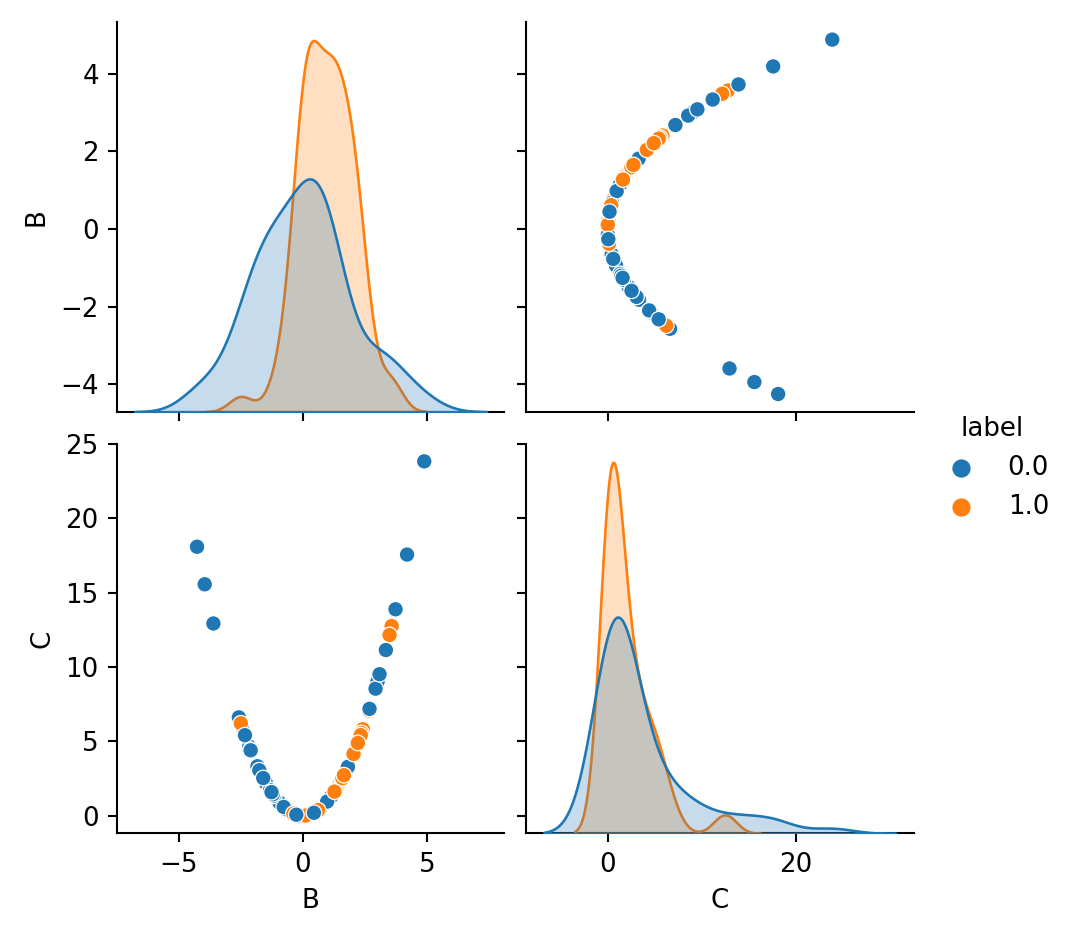

In [4]:
import seaborn as sns
import pandas as pd
df = pd.DataFrame(pd.DataFrame(X_train, columns=list('ABC')))
df = pd.concat([df, pd.DataFrame(y_train, columns=['label'])], axis=1)
df.head()
                
sns.pairplot(df[['B', 'C', 'label']], hue='label')

In [5]:
def logit_gibbs(X, y, 
                alpha = 2,
                max_iter = 10000,
                random_state=None):
    
    if random_state is None:
        random_state = np.random.RandomState()
    
    burn_in = max_iter//20

    rng = random_state._bit_generator 
                
    # preprocessing
    kappa = y_train - 0.5

    # initialize `beta`
    latent_dim = X.shape[-1]
    beta = random_state.normal(size=latent_dim, scale=1/np.sqrt(alpha))

    betas=[]
    sigmas = []
    for i in range(max_iter):
        # sample z
        b, c = get_pg_params(X, beta)
        z = polya_gamma_sample(b, c, rng)

        # sample beta
        mu, Sigma = get_beta_params(X, kappa, alpha, z)
        beta = gassian_sample(mu, Sigma, random_state=random_state)

        # save it for late anysis
        betas.append(beta)
        sigmas.append(Sigma)
    
    return betas[burn_in:], sigmas[burn_in:]


<IPython.core.display.Javascript object>


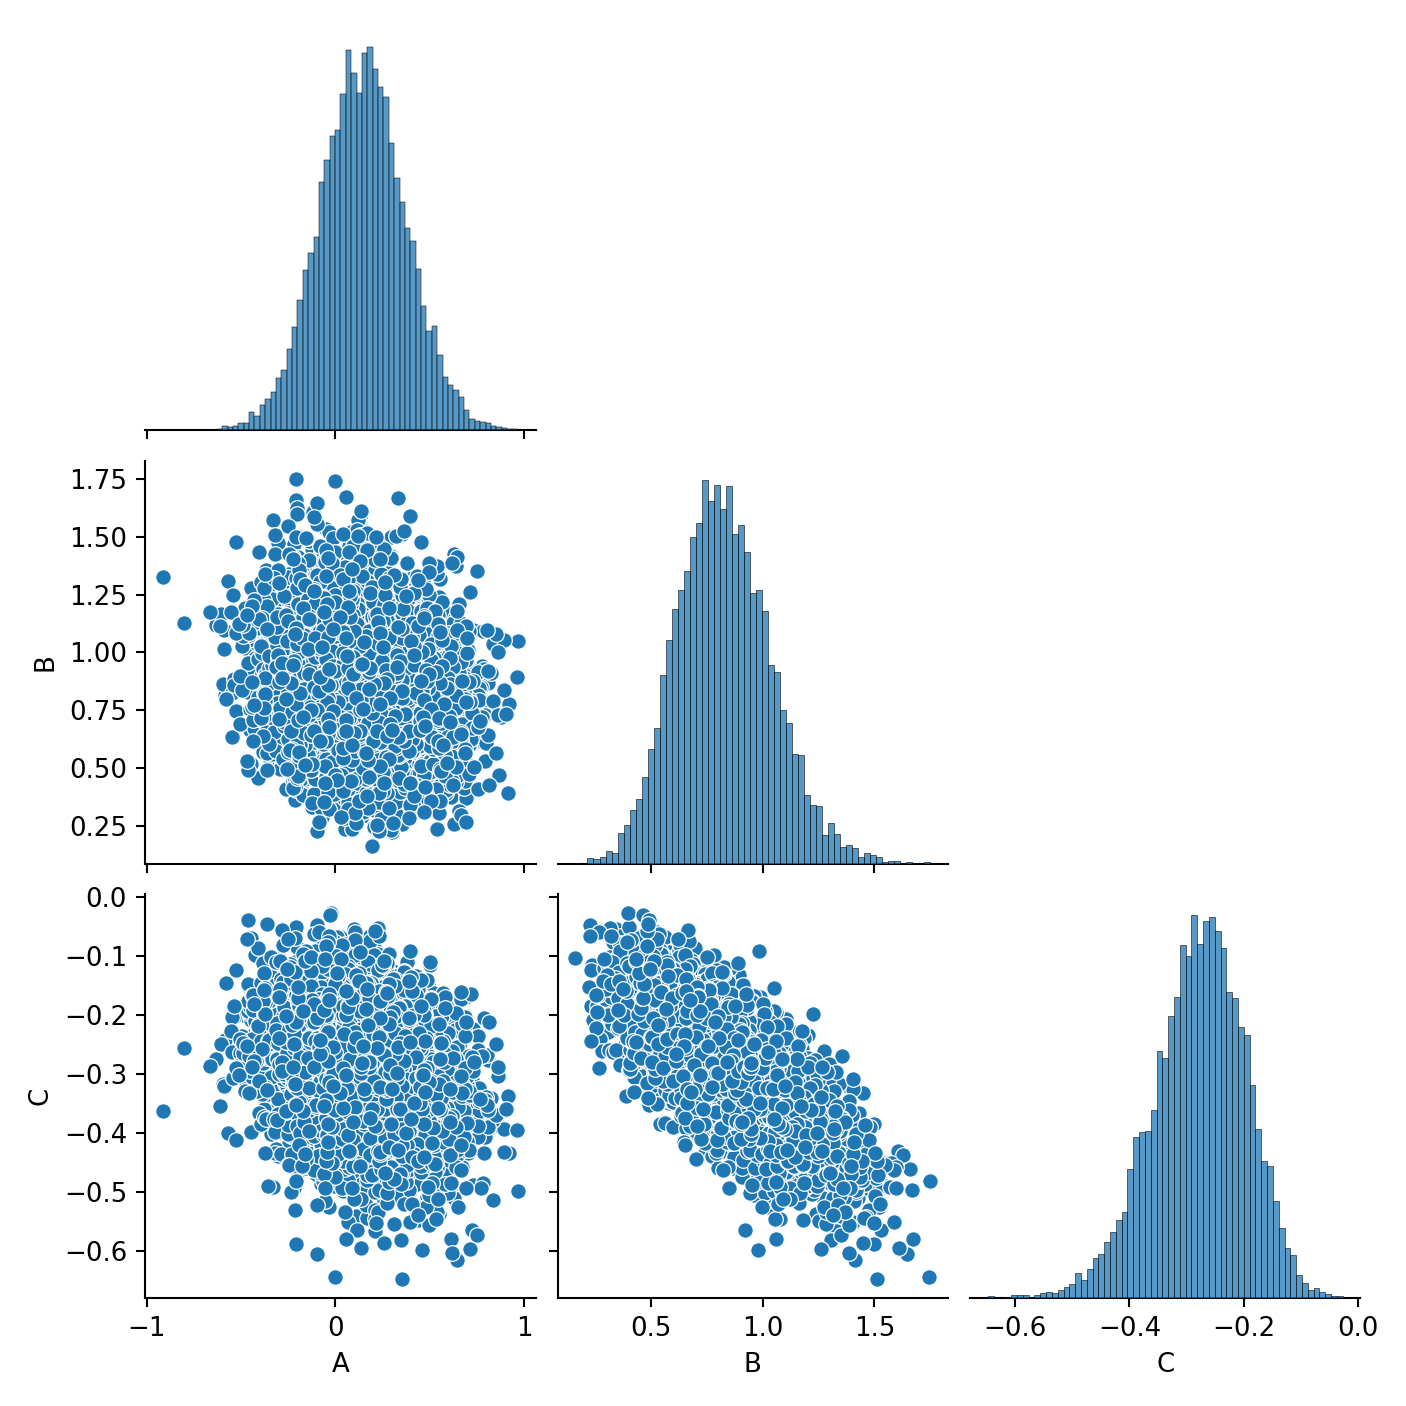

In [7]:
num_iterations = 10000
alpha = 2.0  # prior precision

betas, sigmas = logit_gibbs(X_train, y_train, max_iter=num_iterations, alpha=alpha)

betas = pd.DataFrame(betas, columns=list('ABC'))
sns.pairplot(betas, corner=True)

In [8]:
def logit_em(X, y, tol = 1e-16, 
             reg = 0,
             max_iter = 10000, 
             random_state=None):
    if random_state is None:
        random_state = np.random.RandomState()
        
    # init
    p = X.shape[-1]
    beta = random_state.normal(size=p)
    Xy = X.T @ (y-0.5)
    z = X @ beta
    w = np.tanh(z/2) / (2*z)
    w[np.isinf(w)] = 0.25
    loglik = [sum(y * z - np.log(1+np.exp(z)))]
    betas = [beta]
    precisions = [None]

    for t in range(1, max_iter):
        precision = (X * w[:,None]).T @ X + reg*np.eye(p)
        beta = np.linalg.solve(precision, Xy)
        z = X @ beta
        w = np.tanh(z/2) / (2*z)
        w[np.isinf(w)] = 0.25
        
        loglik.append(sum(y * z - np.log(1+np.exp(z))))
        betas.append(beta)
        precisions.append(precision)
        
        if np.abs(loglik[t] - loglik[t-1]) < tol:
            print(f"Reach convergence at {t} iters with beta: {beta}")
            break
    return betas, precisions, loglik
        


In [9]:
betas_2, precisions_2, loglik_2 = logit_em(X_train, y_train, reg=2)


Reach convergence at 67 iters with beta: [ 0.14467458  0.77856652 -0.2582548 ]


In [10]:
np.array(betas_2[-10:]).mean(axis=0)

array([ 0.14467458,  0.77856652, -0.2582548 ])

In [11]:
np.array(betas[-100:]).mean(axis=0)

array([ 0.12977487,  0.86572934, -0.29061017])

In [12]:
sigmas[-1]

array([[ 0.03758592, -0.00044663, -0.00440537],
       [-0.00044663,  0.01908608, -0.0029434 ],
       [-0.00440537, -0.0029434 ,  0.00285985]])

In [13]:
np.linalg.inv(precisions_2[-1])

array([[ 0.04494416, -0.00330769, -0.00483545],
       [-0.00330769,  0.01969727, -0.00355084],
       [-0.00483545, -0.00355084,  0.00296536]])

In [14]:
precisions_2[-3:], loglik_2[-3:]

([array([[ 31.54544976,  18.5813892 ,  73.68952083],
         [ 18.5813892 ,  75.68952083, 120.9332914 ],
         [ 73.68952083, 120.9332914 , 602.19860661]]),
  array([[ 31.54544976,  18.5813892 ,  73.68952083],
         [ 18.5813892 ,  75.68952083, 120.9332914 ],
         [ 73.68952083, 120.9332914 , 602.19860661]]),
  array([[ 31.54544976,  18.5813892 ,  73.68952083],
         [ 18.5813892 ,  75.68952083, 120.9332914 ],
         [ 73.68952083, 120.9332914 , 602.19860661]])],
 [-74.80957961599564, -74.8095796159957, -74.8095796159957])

In [122]:
def logit_em_online(X, y, tol = 1e-2, reg = 0,
             max_iter = 10000, 
             random_state=None):
    if random_state is None:
        random_state = np.random.RandomState()
        
    # init
    lr = 0.005
    p = X.shape[-1]
    beta = random_state.normal(size=p)
    precision = reg*np.eye(p)

    betas = [beta]
    precisions = [precision]
    loglik = [-np.inf]

    for t in range(1, max_iter):
        lr *= 0.9
        
        X, y = shuffle(X, y)
        # precision = reg*np.eye(p)
        for x_i, y_i in zip(X, y):
            # E_step
            z_i = x_i.dot(beta)
            w_i = np.tanh(z_i/2) / (2*z_i)
            if np.isinf(w_i):
                w_i = 0.25
            
            # M_step
            delta_precision = (x_i*w_i).T @ x_i
            precision = (1-lr)*precision + lr*delta_precision
            # precision = (1-decay)*precision + delta_precision
                
            Xy = x_i.T * (y_i-0.5)
            delta_beta = np.linalg.solve(precision, Xy)
            beta = (1-lr) * beta + lr * delta_beta

        z = X @ beta
        _llk = sum(y * z - np.log(1+np.exp(z)))
        print(f"{t} iteration log lik is {_llk}")
        loglik.append(_llk)
        betas.append(beta)
        precisions.append(precision)

        # if np.abs(loglik[t] - loglik[t-1]) < tol:
        if (loglik[t] < loglik[t-1]):
            print(f"Early stop at {t} iters with beta: {beta}")
            break
    return betas, precisions, loglik
        

In [123]:
betas_3, precisions_3, loglik_3 = logit_em_online(X_train, y_train, reg=2)

1 iteration log lik is -105.6886235878723
2 iteration log lik is -79.7250661532272
3 iteration log lik is -80.98422985617763
Early stop at 3 iters with beta: [ 0.06088249  0.47039952 -0.30794103]


In [126]:
betas_2[-2]

array([ 0.14467458,  0.77856652, -0.2582548 ])

In [127]:
precisions_3[-3:], loglik_3[-3:]

([array([[2.76158258, 1.6387582 , 1.6387582 ],
         [1.6387582 , 2.76158258, 1.6387582 ],
         [1.6387582 , 1.6387582 , 2.76158258]]),
  array([[3.92651697, 3.25860929, 3.25860929],
         [3.25860929, 3.92651697, 3.25860929],
         [3.25860929, 3.25860929, 3.92651697]]),
  array([[4.62181034, 4.20328494, 4.20328494],
         [4.20328494, 4.62181034, 4.20328494],
         [4.20328494, 4.20328494, 4.62181034]])],
 [-105.6886235878723, -79.7250661532272, -80.98422985617763])

In [128]:
precisions_2[-3:], loglik_2[-3:]

([array([[ 31.54544976,  18.5813892 ,  73.68952083],
         [ 18.5813892 ,  75.68952083, 120.9332914 ],
         [ 73.68952083, 120.9332914 , 602.19860661]]),
  array([[ 31.54544976,  18.5813892 ,  73.68952083],
         [ 18.5813892 ,  75.68952083, 120.9332914 ],
         [ 73.68952083, 120.9332914 , 602.19860661]]),
  array([[ 31.54544976,  18.5813892 ,  73.68952083],
         [ 18.5813892 ,  75.68952083, 120.9332914 ],
         [ 73.68952083, 120.9332914 , 602.19860661]])],
 [-74.80957961599564, -74.8095796159957, -74.8095796159957])